In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
from dask_gateway import Gateway
from dask.distributed import Client
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt()
client = Client(cluster)
cluster

# # this block starts clusters we will need for fast parallel? calculations
# from dask_gateway import Gateway
# from dask.distributed import Client
# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=2, maximum=20)
# client = Client(cluster)
# cluster

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import os.path
import xesmf as xe
from scipy.signal import detrend

In [5]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#         print(model, var, "found data")
    except:
        ds = []
        #print(model, var, "no data")
    return ds        

In [6]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
# models with ssp585 experiment
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']


# models = ['CESM2-WACCM', 'GFDL-CM4']

# expe = 'ssp585'
# freq = 'Omon'
# start_year = '2081'
# end_year = '2100'
# var = 'chl'
# var2 = var+'os'

# xrays = []
# new_models = []

# for model in models:
#     print(model)
#     xray = get_data(df, var2, model, expe, freq)
#     xray1 = get_data(df, var, model, expe, freq) # no os
    
#     # if xray is not empty
#     if isinstance(xray, xr.Dataset): 
#         xrays.append(xray)  
#         new_models.append(model)
#     elif  isinstance(xray1, xr.Dataset): 
#         xrays.append(xray)  
#         new_models.append(model)
        
        
# xray_dic = {key:value for key, value in zip(new_models, xrays)}
# print(len(new_models))

In [7]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [8]:
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']
# models = ['CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']
# models = ['CESM2-WACCM', 'GFDL-CM4']
# var_names=['phyc','chl','phydiat','zooc','tos']
# var_names = ['phyc', 'chl', 'phydiat', 'zooc','intpp','epc100','fgco2','spco2','dfe','no3','si','tos','omldamax','hfds','rsntds']
var_names = ['no3','si']
#
# expe = 'historical'
# freq = 'Omon'
# start_year = '1995'
# end_year = '2014'
# diff = 2014-1995+1

expe = 'historical'
freq = 'Omon'
start_year = '1991'
end_year = '2010'

# n_slice_low = 45
# n_slice_high = 60

# n_slice_low = 60
# n_slice_high = 90

# n_slice_low_list = [60,50,40,10,-10,-40,-50,-60,-90]
# n_slice_high_list = [90,60,50,40,10,-10,-40,-50,-60]

# length = 1

#new_models = ['GISS-E2-1-G', 'GISS-E2-1-G-CC']
# new_vars = ['phydiat']   # new models aren't working here. 
xxray_in = []
# true_var = 'phydiat'
for model in models:
    print(model)
    for var in var_names:
        vvar = var + 'os'
        xray = get_data(df, vvar, model, expe, freq)
        if isinstance(xray, xr.Dataset):
            xxray_in = xray
            
        else:
            vvar = var    
            xray = get_data(df, vvar, model, expe, freq)
            xxray_in= xray
            
        if ((model == 'MPI-ESM1-2-HR' and (var == 'zooc' or var == 'si')) or
            (model == 'MRI-ESM2-0' and var == 'chl') or
            (model == 'UKESM1-0-LL' and (var == 'phydiat'or var == 'chl')) or
            (model == 'CNRM-ESM2-1' and var == 'dfe')):
            print('wont work')
        else:
#             print("so far good")
            if isinstance(xxray_in, xr.Dataset):
#                     print("instance")
                    
                    ds = xxray_in.sel(time=slice(start_year, end_year))[vvar]

                    if 'latitude' in ds.coords:
                        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
                    if 'nav_lat' in ds.coords:
                        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

                    if 'lev_partial' in ds.coords:
                        ds = ds.isel(lev_partial=0)
                    if 'olevel' in ds.coords:
                        ds = ds.isel(olevel=0)
                    if 'lev' in ds.coords:
                        ds = ds.isel(lev=0)

                    if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                        if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                            ds = ds.where(ds>=0)

                    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
                    dsr._grid_in = None
                    dsr._grid_out = None
                    dsr_out0 = dsr(ds)
                    dsr_out = xr.Dataset({var:dsr_out0})

#                     print(dsr_out[var].shape[0])
                    if dsr_out[var].shape[0]==12*20: #5 years 12 months
                        print(var)
                        ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220)) #45 north, 210 east
                        dsm_np = ds_np[var].mean(dim='time',skipna=1)
                        anom_np = ds_np[var] - dsm_np
                        anom_np.load()
    #                     anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0), anom_np.chunk({"lon":45,"lat":45}), kwargs={'axis': 0}).where(~anom_np.isnull())
                        anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0).chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anom_np.dtype]).where(~anom_np.isnull())
                        detrend_np = anom_detrended_np + dsm_np
                        do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
#                         if var == 'spco2':
#                             do_np = do_np / 0.101325
#                         if var == 'phyc' or var == 'phycos':
#                             do_np = do_np * 12000 # more info
#                         if var == 'phycdiat'or var == 'phycdiatos':
#                             do_np = do_np * 12000 # more info
#                         if var == 'fgco2':
#                             do_np = do_np * 3600 * 24 * 365 * 1000 / (44/12) 

                        savef_np = '/home/jovyan/GitTasks/GitData/' + model + '_' + var + '_np.txt'
                        with open(savef_np, 'w') as npf:
                            for idata in do_np:
                                npf.write(str(idata) +"\n")
                        
                        ds_na = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(325,335))
                        dsm_na = ds_na[var].mean(dim='time', skipna=1)
                        anom_na = ds_na[var] - dsm_na
                        anom_na.load()
                        anom_detrended_na = xr.apply_ufunc(detrend, anom_na.fillna(0),kwargs={'axis': 0}, dask="parallelized", output_dtypes=[anom_na.dtype]).where(~anom_na.isnull())
                        detrend_na = anom_detrended_na + dsm_na
                        do_na = detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
#                         if var == 'spco2':
#                             do_na = do_na / 0.101325
#                         if var == 'phyc' or var == 'phycos':
#                             do_na = do_na * 12000 # more info
#                         if var == 'phycdiat'or var == 'phycdiatos':
#                             do_na = do_na * 12000 # more info
#                         if var == 'fgco2':
#                             do_na = do_na * 3600 * 24 * 365 * 1000 / (44/12) 

                        savef_na = '/home/jovyan/GitTasks/GitData/' + model + '_' + var + '_na.txt'
                        with open(savef_na, 'w') as naf:
                            for idata in do_na:
                                naf.write(str(idata) +"\n")
                        
#                         ds_exp = dsr_out.sel(lat=slice(-13,-18)).sel(lon=slice(45,50))
#                         dsm_exp = ds_exp[var].mean(dim='time', skipe=1)
#                         anom_exp = ds_exp[var] - dsm_exp
#                         anom_exp.load()
#                         anom_detrended_exp = xr.apply_ufunc(detrend, anom_exp.fillna(0),kwargs={'axis': 0}, dask="parallelized", output_dtypes=[anom_exp.dtype]).where(~anom_exp.isnull())
#                         detrend_exp = anom_detrended_exp + dsm_exp
#                         do_exp = detrend_exp.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
# #                         if var == 'spco2':
# #                             do_na = do_na / 0.101325
# #                         if var == 'phyc' or var == 'phycos':
# #                             do_na = do_na * 12000 # more info
# #                         if var == 'phycdiat'or var == 'phycdiatos':
# #                             do_na = do_na * 12000 # more info
# #                         if var == 'fgco2':
# #                             do_na = do_na * 3600 * 24 * 365 * 1000 / (44/12) 

#                         savef_na = '/home/jovyan/PythonCodes/GitTasks/GitData/' + model + '_' + var + '_exp.txt'
#                         with open(savef_exp, 'w') as expf:
#                             for idata in do_exp:
#                                 expf.write(str(idata) +"\n")
                         

CESM2-WACCM
no3
si
CESM2
no3
si
GFDL-CM4
GFDL-ESM4
no3
si
IPSL-CM6A-LR
no3
si
GISS-E2-1-G
no3
si
GISS-E2-1-G-CC
no3
si
MIROC-ES2L
no3
NorCPM1
NorESM2-LM
no3
si
MPI-ESM1-2-HR
no3
wont work
MPI-ESM1-2-LR
no3
si
UKESM1-0-LL
no3
si
CNRM-ESM2-1
no3
si
ACCESS-ESM1-5
no3
CanESM5-CanOE
no3
CanESM5
no3
EC-Earth3


In [82]:
filelist = []
filename0 = '/home/jovyan/WOA_Data/woa18_all_n'
filename1 = '_01.nc'
for i in range(1,13):
    filenum = '{:0>2d}'.format(i)
    filename = filename0 + filenum + filename1
    filelist.append(filename)
    
woa_ds = xr.open_mfdataset(filelist, chunks = 'auto', decode_times = False)

In [83]:
woa_ds

<xarray.Dataset>
Dimensions:             (depth: 43, lat: 180, lon: 360, nbounds: 2, time: 12)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 15.0 ... 700.0 750.0 800.0
  * time                (time) float64 696.5 697.5 698.5 ... 705.5 706.5 707.5
Dimensions without coordinates: nbounds
Data variables:
    crs                 (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds            (time, lat, nbounds) float32 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lon_bnds            (time, lon, nbounds) float32 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    depth_bnds          (time, depth, nbounds) float32 dask.array<chunksize=(1, 43, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    n_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_ma                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
    n_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 43, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : moles_concentra...
    summary:                         Climatological mean dissolved inorganic ...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    id:                              woa18_all_n01_01.nc
    naming_authority:                gov.noaa.ncei
    sea_name:                        World-Wide Distribution
    time_coverage_start:             1900-01-01
    time_coverage_end:               2017-01-31
    time_coverage_duration:          P!!Y
    time_coverage_resolution:        P01M
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         800.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       1.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       1.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NCEI.info@noaa.gov
    creator_url:                     http://www.ncei.noaa.gov
    creator_type:                    group
    creator_institution:             National Centers for Environmental Infor...
    project:                         World Ocean Atlas Project
    processing_level:                processed
    keywords:                        Oceans<Ocean Nutrients > Dissolved Inorg...
    keywords_vocabulary:             ISO 19115
    standard_name_vocabulary:        CF Standard Name Table v49
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of clim

In [84]:
woa_no3 = woa_ds_N.n_an

In [99]:
WOA_N_NP = woa_no3.sel(depth = 0.0).sel(lat=slice(45,50)).sel(lon=slice(30,40)).mean(dim="lon").mean(dim="lat").values
WOA_N_NA = woa_no3.sel(depth = 0.0).sel(lat=slice(45,50)).sel(lon=slice(145,155)).mean(dim="lon").mean(dim="lat").values

In [100]:
filelist = []
filename0 = '/home/jovyan/WOA_Data/woa18_all_i'
filename1 = '_01.nc'
for i in range(1,13):
    filenum = '{:0>2d}'.format(i)
    filename = filename0 + filenum + filename1
    filelist.append(filename)
    
woa_ds_Si = xr.open_mfdataset(filelist, chunks = 'auto', decode_times = False)

In [101]:
woa_si = woa_ds_Si.i_an

In [102]:
WOA_Si_NP = woa_si.sel(depth = 0.0).sel(lat=slice(45,50)).sel(lon=slice(30,40)).mean(dim="lon").mean(dim="lat").values
WOA_Si_NA = woa_si.sel(depth = 0.0).sel(lat=slice(45,50)).sel(lon=slice(145,155)).mean(dim="lon").mean(dim="lat").values

In [103]:
WOA_Si_NA

array([23.407429, 40.11042 , 39.629406, 38.646534, 26.277115, 19.682493,
       11.829702, 14.618036,  9.309921, 18.37485 , 17.531382, 21.798285],
      dtype=float32)

In [104]:
Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');
start_year = 1991
end_year = 2010
var_names=['no3','si']

models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR','GISS-E2-1-G','GISS-E2-1-G-CC','MIROC-ES2L',
          'NorCPM1', 'NorESM2-LM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','UKESM1-0-LL','CNRM-ESM2-1','ACCESS-ESM1-5','CanESM5-CanOE','CanESM5', 
          'EC-Earth3']

# plot_titles=['Biomass (mgC/m3)','Chlorophyll (kg/m3)','Diatom (mgC/m3)', 
#              'Zooplankton (mgC/m3)','Primary Production (mgC/m2/s)','Export Production at 100m (mol/m2/s)',
#              'Air-sea CO2 flux (donward +) (gram C /m2/year)','SpCO2 (ppm)', 'Iron - Fe (mol/m3)', 
#              'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light - Surface Downward SW Radiation (W/m2)']

plot_titles = ['Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)'] 


# plot_ranges=[[-0.001,0.0175], [-0.1e-6,3e-6], [-0.0005, 0.010], [-0.0005,0.008], 
#plot_ranges=[[-0.001,180], [-0.1e-6,3e-6], [-0.0005, 120], [-0.0005,100],              
            # [-0.05e-6,15e-3], [-0.1e-7,2.5e-7], [-60,85], [800, 1200],  
             #[-0.1e-7,1e-6], [-0.001,0.0175], [-0.001,0.012], [0,250]]
        
plot_ranges = [[-0.001,0.0175],[-0.001,0.012]
              ]

colors = [[255, 255, 38], [255, 255, 38], [255,209, 35],
          [255, 157, 9], [255, 2, 2], [255, 148, 255],
          [255, 6, 255], [127, 245, 206], [26, 136, 255],
          [26, 136, 255], [17, 137, 17], [17, 137, 17],
          [8, 8, 126], [130, 55, 6], [112, 48, 160],
          [92, 92, 255], [92, 92, 255], [4, 2, 0]]
newcolors = []
for color in colors:
    newcolors.append([x/255.0 for x in color])
Colors=newcolors

print(var_names)

['no3', 'si']


no3
1
si
2
CPU times: user 5.65 s, sys: 61.6 ms, total: 5.71 s
Wall time: 5.72 s


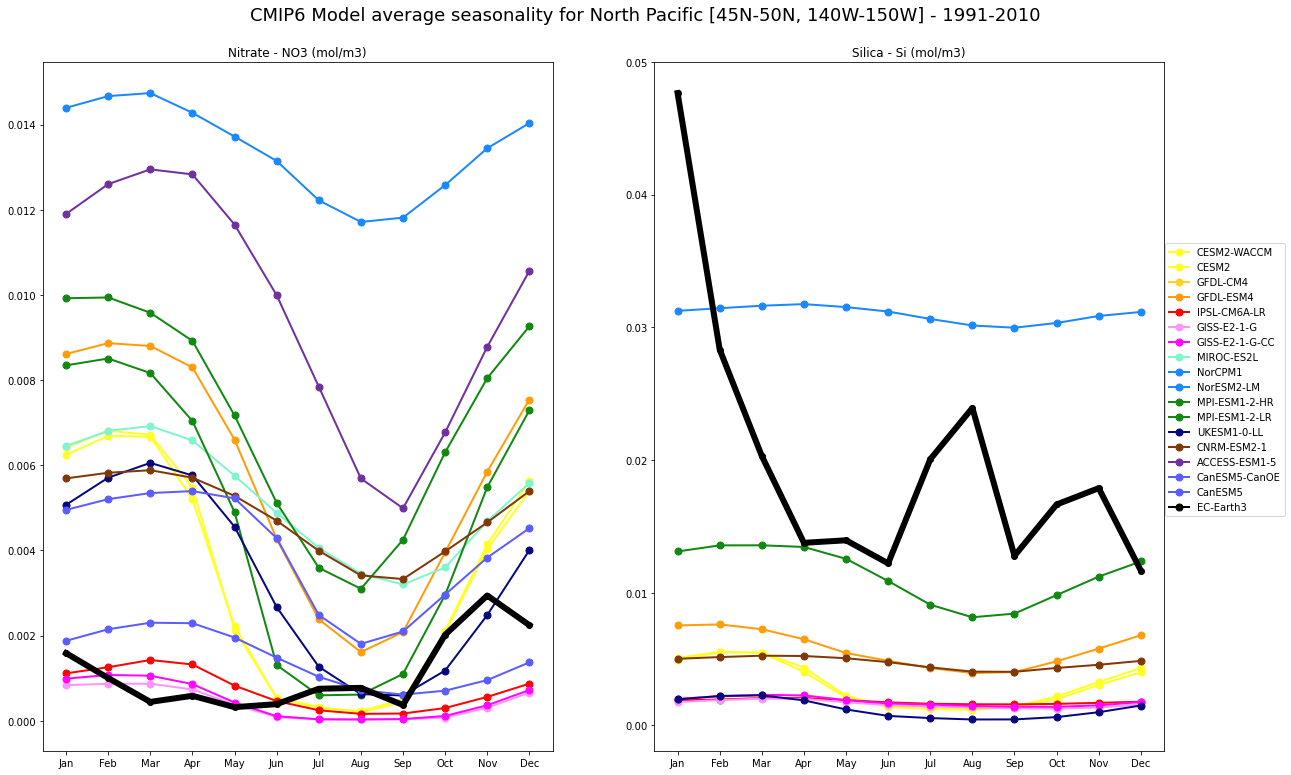

In [105]:
%%time

# plotting North Pacific

fig = plt.figure(figsize=(18, 11))
ncol = 1
nrow = 2
i = 0
# var_names = ['phydiat']
for var in var_names:
    
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    print(var)
    mi = 0
    for model in models:
        
        ofn = '/home/jovyan/GitTasks/GitData/' + str(model) + '_' + str(var) + '_np.txt'
        if os.path.exists(ofn):
#             print(os.path.exists(ofn))    
            dm = []
            with open(ofn, "r") as rf:
                
                for line in rf:
                    dm.append(float(line.strip()))
                    
            xmon = np.arange(1, 13)
            s = np.array(dm)

         ## DONE in regridding
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation, why???
            if var == 'phyc' or var=='phycos':
                s = s * 12000 # 
            if var == 'phydiat' or var == 'phydiatos':
                s = s * 12000 # 
            if var == 'zooc' or var == 'zoocos':
                s = s * 12000 # 
            if var == 'intpp': 
                s = s * 12000 #
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), marker='o', markersize=7, linewidth=2.0)
#             
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#             print('check6')
        mi = mi +1
#         print(mi)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    print(i)
    #plt.ylim(plot_ranges[i-1])
    if var == 'no3':
        plt.plot(xmon,WOA_N_NP/1000,c='black',label = "WOA_data_N",marker = 'o', linewidth = 6)
    else:
        plt.plot(xmon,WOA_Si_NP/1000,c='black',label = "WOA_data_Si",marker = 'o', linewidth = 6)   
        
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12, y=1)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/GitTasks/NO3-Si_NP_1991-2010.png', dpi=600)

no3
1
si
2
CPU times: user 5.72 s, sys: 58.4 ms, total: 5.78 s
Wall time: 5.82 s


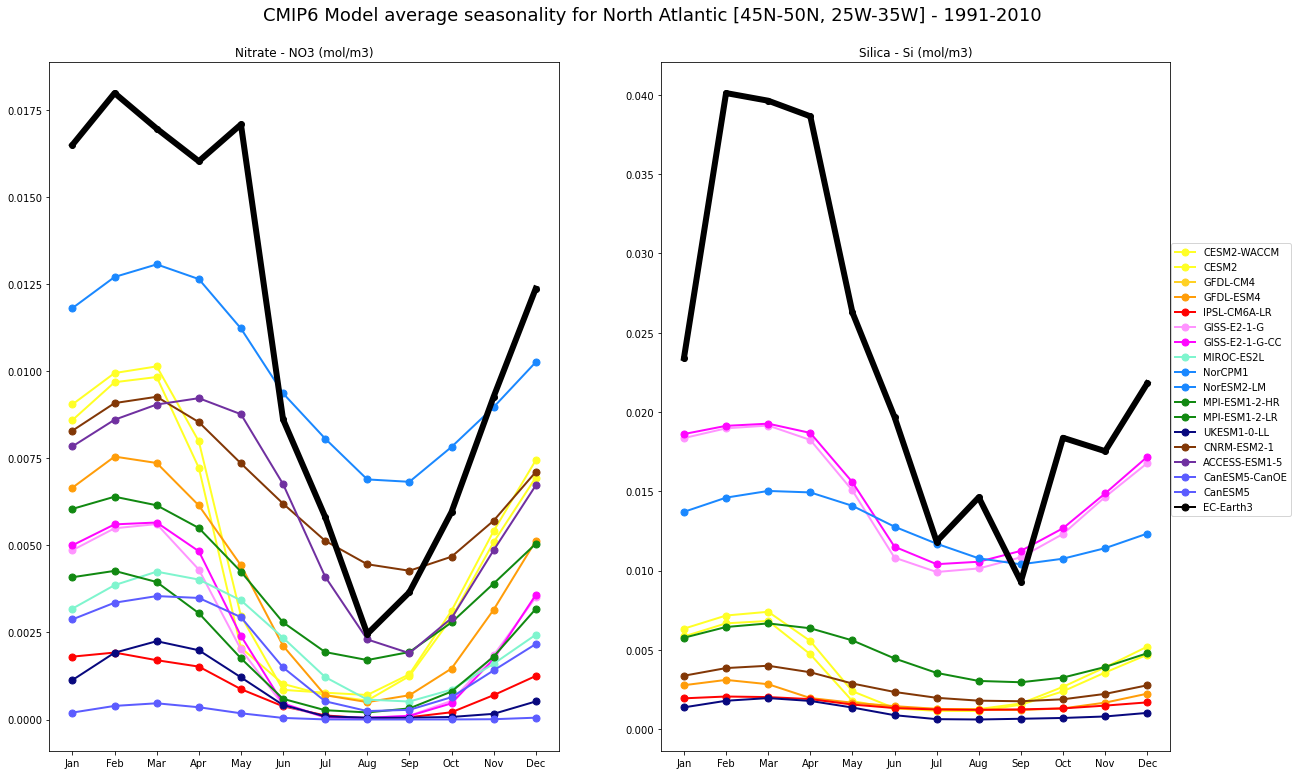

In [106]:
%%time

# plotting North Atlantic

fig = plt.figure(figsize=(18, 11))
ncol = 1
nrow = 2
i = 0
# var_names = ['phydiat']
for var in var_names:
    
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    print(var)
    mi = 0
    for model in models:
        
        ofn = '/home/jovyan/GitTasks/GitData/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofn):
#             print(os.path.exists(ofn))    
            dm = []
            with open(ofn, "r") as rf:
                
                for line in rf:
                    dm.append(float(line.strip()))
                    
            xmon = np.arange(1, 13)
            s = np.array(dm)

         ## DONE in regridding
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation, why???
            if var == 'phyc' or var=='phycos':
                s = s * 12000 # 
            if var == 'phydiat' or var == 'phydiatos':
                s = s * 12000 # 
            if var == 'zooc' or var == 'zoocos':
                s = s * 12000 # 
            if var == 'intpp': 
                s = s * 12000 #
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), marker='o', markersize=7, linewidth=2.0)
#             
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#             print('check6')
        mi = mi +1
#         print(mi)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    print(i)
    #plt.ylim(plot_ranges[i-1])
    if var == 'no3':
        plt.plot(xmon,WOA_N_NA/1000,c='black',label = "WOA_data_N",marker = 'o', linewidth = 6)
    else:
        plt.plot(xmon,WOA_Si_NA/1000,c='black',label = "WOA_data_Si",marker = 'o', linewidth = 6)   
        
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12, y=1)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/GitTasks/NO3-Si_NA_1991-2010.png', dpi=600)